## NLP - Movie Genre prediction based on movie description

#### 1. Text Cleaning & Processing
* Cleaning
* Normalization
* Tokenization
* Stop word removal
* POS - parts of speech tagging
* NER - named entity recognition
* Stemming & Lemmatization

#### 2. Feature Extraction
* Bag of Words
* TF-IDF (term frequency–inverse document frequency)
* Word embeddings

#### 3. Modeling

#### Practice notebook referring tutorial - https://www.kaggle.com/lykin22/movies-genre-classification-nlp

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
# Imports
import io
import sys
import json
import math
import nltk

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from PIL import Image
from plotly import __version__
from collections import Counter

# For Text pre-processing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, pos_tag_sents

# Sklearn
# Performance metrics
from sklearn.metrics import f1_score 
from sklearn.metrics import accuracy_score
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier 
# Model
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Visualize
from wordcloud import WordCloud, STOPWORDS

In [3]:
## Read the movie genres dataset 
# https://www.kaggle.com/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows
df = pd.read_csv('movie_genres.csv',encoding = "ISO-8859-1", engine='python')
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [8]:
df.shape

(1000, 16)

In [4]:
df = df[['Series_Title','Genre','Overview']]
df.columns = ['title','genre','overview']
df.head()

,title,genre,overview
0,The Shawshank Redemption,Drama,Two imprisoned men bond over a number of years...
1,The Godfather,"Crime, Drama",An organized crime dynasty's aging patriarch t...
2,The Dark Knight,"Action, Crime, Drama",When the menace known as the Joker wreaks havo...
3,The Godfather: Part II,"Crime, Drama",The early life and career of Vito Corleone in ...
4,12 Angry Men,"Crime, Drama",A jury holdout attempts to prevent a miscarria...


### Clean text overview

In [5]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/heena.otia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
## Clean the movie overview text
def text_preprocess(sentence):
    # convert text to lowercase
    sentence=str(sentence)
    sentence = sentence.lower()
    
    # A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence) 

    # Remove stopwords
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]

    # Stemming the words (eg. Studies => Studi)
    stemmer = PorterStemmer()
    stem_words=[stemmer.stem(w) for w in filtered_words]

    # Lemmatize (eg. Studies => Study)
    lemmatizer = WordNetLemmatizer()
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


In [7]:
df['clean_overview'] = df['overview'].apply(text_preprocess)
df.head()

,title,genre,overview,clean_overview
0,The Shawshank Redemption,Drama,Two imprisoned men bond over a number of years...,two imprisoned men bond number years finding s...
1,The Godfather,"Crime, Drama",An organized crime dynasty's aging patriarch t...,organized crime dynasty aging patriarch transf...
2,The Dark Knight,"Action, Crime, Drama",When the menace known as the Joker wreaks havo...,menace known joker wreaks havoc chaos people g...
3,The Godfather: Part II,"Crime, Drama",The early life and career of Vito Corleone in ...,early life career vito corleone 1920s new york...
4,12 Angry Men,"Crime, Drama",A jury holdout attempts to prevent a miscarria...,jury holdout attempts prevent miscarriage just...


In [8]:
df.overview[0]

'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.'

In [9]:
df.clean_overview[0]

'two imprisoned men bond number years finding solace eventual redemption acts common decency'

### Clean genres

In [10]:
df['genre'] = df['genre'].fillna(0)
df['genre'] = df['genre'].astype(str)
df = df[df['genre']!='0']
df = df.assign(genre_split = df.genre.map(lambda x: x.split(",")))
df = df.assign(genre_1 = df.genre.map(lambda x: x.split(",")[0]))
df.head()

,title,genre,overview,clean_overview,genre_split,genre_1
0,The Shawshank Redemption,Drama,Two imprisoned men bond over a number of years...,two imprisoned men bond number years finding s...,[Drama],Drama
1,The Godfather,"Crime, Drama",An organized crime dynasty's aging patriarch t...,organized crime dynasty aging patriarch transf...,"[Crime, Drama]",Crime
2,The Dark Knight,"Action, Crime, Drama",When the menace known as the Joker wreaks havo...,menace known joker wreaks havoc chaos people g...,"[Action, Crime, Drama]",Action
3,The Godfather: Part II,"Crime, Drama",The early life and career of Vito Corleone in ...,early life career vito corleone 1920s new york...,"[Crime, Drama]",Crime
4,12 Angry Men,"Crime, Drama",A jury holdout attempts to prevent a miscarria...,jury holdout attempts prevent miscarriage just...,"[Crime, Drama]",Crime


In [11]:
df.genre_1.unique()

array(['Drama', 'Crime', 'Action', 'Biography', 'Western', 'Comedy',
       'Adventure', 'Animation', 'Horror', 'Mystery', 'Film-Noir',
       'Fantasy', 'Family', 'Thriller'], dtype=object)

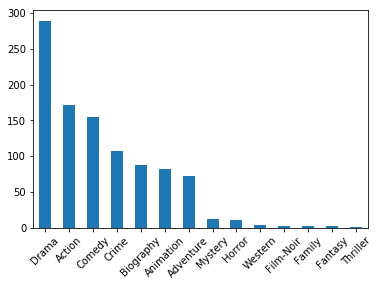

In [12]:
df['genre_1'].value_counts().plot(kind='bar',rot=45)

In [13]:
## List the top frequest keywords in show overview
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## Get top 25 Frequent keywords
wordcount_list = df['clean_overview'].tolist()
freq_keywords = get_top_n_words(wordcount_list,25)

df_wordcounts = pd.DataFrame(freq_keywords, columns=['words','freq'])
df_wordcounts

,words,freq
0,young,132
1,man,119
2,life,111
3,two,104
4,world,85
5,new,73
6,family,66
7,war,66
8,woman,65
9,story,63


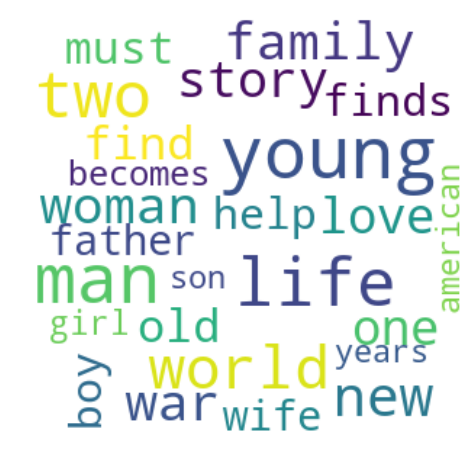

In [14]:
# wordcloud
wordcloud = WordCloud(width = 300, 
                      height = 300,
                      background_color='white', 
                      max_font_size=50,
                      max_words=150
                     )

wordcloud = wordcloud.generate_from_frequencies(df_wordcounts.set_index('words').freq)

# plot words
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.tight_layout(pad=0)
# store to file
# plt.savefig("cloud.png", format="png")
plt.show()

### Building the Model

In [15]:
corpus = df.clean_overview.to_list()

In [16]:
corpus[0]

'two imprisoned men bond number years finding solace eventual redemption acts common decency'

In [112]:
# Creating the Bag of Words model
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
X = cv.fit_transform(corpus).toarray()

In [121]:
y = df['genre_1'].values

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (800, 10000), X_test size: (200, 10000)


In [123]:
# Fitting Naive Bayes to the Training set
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [124]:
# Predicting the Test set results
nb_y_pred = nb_classifier.predict(X_test)

In [125]:
# Calculating Accuracy
from sklearn.metrics import accuracy_score
score1 = accuracy_score(y_test, nb_y_pred)
print("---- Score ----")
print("Accuracy score is: {}%".format(round(score1*100,2)))

---- Score ----
Accuracy score is: 39.5%


In [126]:
test_df = pd.DataFrame({'actuals':y_test,"preds":nb_y_pred})
test_df

,actuals,preds
0,Drama,Comedy
1,Drama,Drama
2,Biography,Drama
3,Adventure,Drama
4,Animation,Drama
...,...,...
195,Comedy,Comedy
196,Action,Action
197,Biography,Comedy
198,Crime,Crime


In [132]:
df.genre_1.unique()

array(['Drama', 'Crime', 'Action', 'Biography', 'Western', 'Comedy',
       'Adventure', 'Animation', 'Horror', 'Mystery', 'Film-Noir',
       'Fantasy', 'Family', 'Thriller'], dtype=object)

In [128]:
# Confusion Matrix
nb_cm = confusion_matrix(y_test, nb_y_pred)

In [129]:
nb_cm

array([[13,  3,  1,  1,  1,  2, 12,  0,  0,  0,  0,  0],
       [ 1,  1,  2,  1,  1,  2,  6,  0,  0,  0,  0,  0],
       [ 3,  0,  4,  0,  3,  0,  9,  0,  0,  0,  0,  0],
       [ 1,  2,  1,  4,  2,  1,  6,  0,  0,  0,  0,  0],
       [ 2,  0,  2,  0,  8,  2, 13,  0,  0,  0,  0,  0],
       [ 3,  0,  1,  0,  4,  7,  6,  0,  0,  0,  0,  0],
       [ 7,  0,  2,  1,  5,  4, 42,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

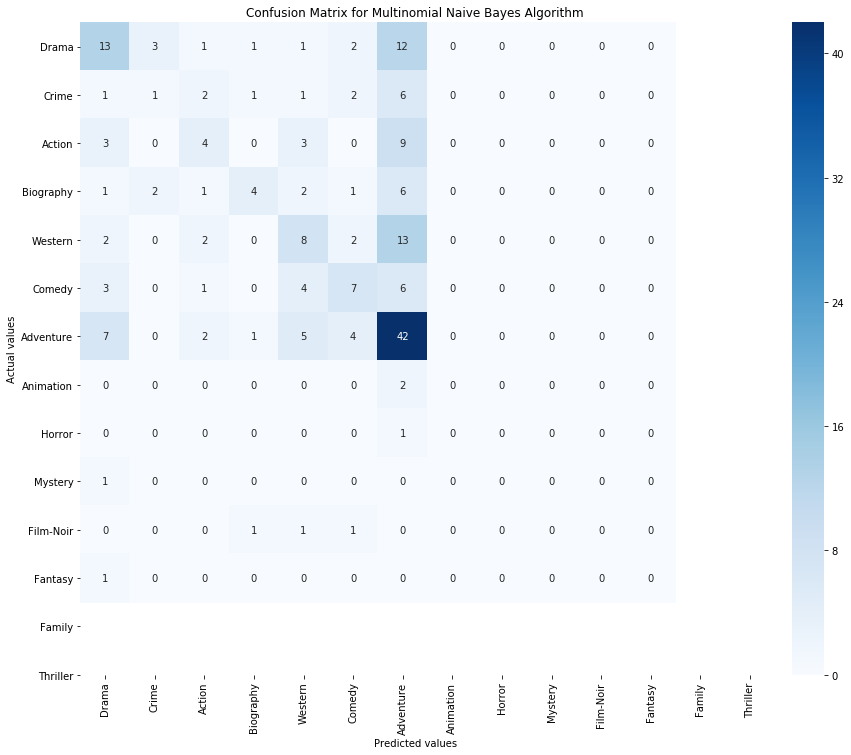

In [133]:
# Plot the confusion matrix
plt.figure(figsize=(15,12))
axis_labels = ['Drama', 'Crime', 'Action', 'Biography', 'Western', 'Comedy',
               'Adventure', 'Animation', 'Horror', 'Mystery', 'Film-Noir',
               'Fantasy', 'Family', 'Thriller']
sns.heatmap(data=nb_cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Multinomial Naive Bayes Algorithm')
plt.show()

In [134]:
# Hyperparameter tuning the Naive Bayes Classifier
best_accuracy = 0.0
alpha_val = 0.0
for i in np.arange(0.1,1.1,0.1):
  temp_classifier = MultinomialNB(alpha=i)
  temp_classifier.fit(X_train, y_train)
  temp_y_pred = temp_classifier.predict(X_test)
  score = accuracy_score(y_test, temp_y_pred)
  print("Accuracy score for alpha={} is: {}%".format(round(i,1), round(score*100,2)))
  if score>best_accuracy:
    best_accuracy = score
    alpha_val = i
print('--------------------------------------------')
print('The best accuracy is {}% with alpha value as {}'.format(round(best_accuracy*100, 2), round(alpha_val,1)))

Accuracy score for alpha=0.1 is: 19.5%
Accuracy score for alpha=0.2 is: 28.5%
Accuracy score for alpha=0.3 is: 33.5%
Accuracy score for alpha=0.4 is: 36.5%
Accuracy score for alpha=0.5 is: 36.5%
Accuracy score for alpha=0.6 is: 37.0%
Accuracy score for alpha=0.7 is: 37.5%
Accuracy score for alpha=0.8 is: 37.5%
Accuracy score for alpha=0.9 is: 37.5%
Accuracy score for alpha=1.0 is: 39.5%
--------------------------------------------
The best accuracy is 39.5% with alpha value as 1.0


In [153]:
classifier = MultinomialNB(alpha = 0.5)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.5)

In [154]:
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
pred_test = cv.fit_transform(df.clean_overview).toarray()

In [155]:
nb_predictions = classifier.predict(pred_test)

In [156]:
df = df.assign(nb_preds = nb_predictions)
df

,title,genre,overview,clean_overview,genre_split,genre_1,nb_preds
0,The Shawshank Redemption,Drama,Two imprisoned men bond over a number of years...,two imprisoned men bond number years finding s...,[Drama],Drama,Drama
1,The Godfather,"Crime, Drama",An organized crime dynasty's aging patriarch t...,organized crime dynasty aging patriarch transf...,"[Crime, Drama]",Crime,Crime
2,The Dark Knight,"Action, Crime, Drama",When the menace known as the Joker wreaks havo...,menace known joker wreaks havoc chaos people g...,"[Action, Crime, Drama]",Action,Action
3,The Godfather: Part II,"Crime, Drama",The early life and career of Vito Corleone in ...,early life career vito corleone 1920s new york...,"[Crime, Drama]",Crime,Crime
4,12 Angry Men,"Crime, Drama",A jury holdout attempts to prevent a miscarria...,jury holdout attempts prevent miscarriage just...,"[Crime, Drama]",Crime,Crime
...,...,...,...,...,...,...,...
995,Breakfast at Tiffany's,"Comedy, Drama, Romance",A young New York socialite becomes interested ...,young new york socialite becomes interested yo...,"[Comedy, Drama, Romance]",Comedy,Comedy
996,Giant,"Drama, Western",Sprawling epic covering the life of a Texas ca...,sprawling epic covering life texas cattle ranc...,"[Drama, Western]",Drama,Biography
997,From Here to Eternity,"Drama, Romance, War","In Hawaii in 1941, a private is cruelly punish...",hawaii 1941 private cruelly punished boxing un...,"[Drama, Romance, War]",Drama,Drama
998,Lifeboat,"Drama, War",Several survivors of a torpedoed merchant ship...,several survivors torpedoed merchant ship worl...,"[Drama, War]",Drama,Drama


In [158]:
print('\nActual Genre: {}'.format(df.genre_1[20]))
print('\nPrediction: {}'.format(df.genre_1[20]))


Actual Genre: Drama

Prediction: Drama


In [159]:
# Calculating Accuracy

score1 = accuracy_score(df.genre_1, df.nb_preds)
print("---- Score ----")
print("Accuracy score is: {}%".format(round(score1*100,2)))

---- Score ----
Accuracy score is: 87.1%
